In [221]:
%reload_ext autoreload
%autoreload 2


In [222]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'DEBUG',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygraphviz

### Step-1. Create a Causal Graph

In [223]:
df = pd.read_csv('loans_causal_schema.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   emp_length                     9183 non-null   float64
 1   state                          10000 non-null  object 
 2   homeownership                  10000 non-null  object 
 3   annual_income                  10000 non-null  float64
 4   debt_to_income                 9976 non-null   float64
 5   delinq_2y                      10000 non-null  int64  
 6   earliest_credit_line           10000 non-null  int64  
 7   inquiries_last_12m             10000 non-null  int64  
 8   total_credit_lines             10000 non-null  int64  
 9   open_credit_lines              10000 non-null  int64  
 10  total_credit_limit             10000 non-null  int64  
 11  total_credit_utilized          10000 non-null  int64  
 12  total_collection_amount_ever   10000 non-null  

In [224]:
#remove unneccessary fields
df.drop(['open_credit_lines', 'total_credit_lines', 
         'total_credit_utilized', 'total_credit_limit',
         'num_accounts_120d_past_due','num_accounts_30d_past_due',
         'num_open_cc_accounts','num_total_cc_accounts',
         ], axis=1, inplace=True)

df.drop(['account_never_delinq_percent','delinq_2y','earliest_credit_line','total_collection_amount_ever',
         'accounts_opened_24m','public_record_bankrupt','num_accounts_past_due','inquiries_last_12m'], axis=1, inplace=True)
df.drop(['loan_status','homeownership'], axis=1, inplace=True)

In [225]:
# we have to remove/fix missing values
df['debt_to_income'] = df['debt_to_income'].interpolate()
df['credit_utilization'] = df['credit_utilization'].interpolate()
df  = df.dropna()

# income high
df['low_income'] = np.where(df['annual_income'] < 35977, True, False)

### Step-1. Create a Causal Graph


#### In this step we will make assumptions and domain knowledge applied to causal graph
Here are a list of assumptions that have then been translated into a Causal Diagram


* employment length, state, homeownership status and annual income play a major role in deciding the status of the loan

* length of employment and the state where borrower lives will definitley affect the anual income.  

* homeownership status will play a role in how many mortgage accounts a borrower will have

* In real world, credit duration is usually an indication of the employment duration ('emp_length'-->'credit_duration')

* 'has_bankrupt_history' --> 'has_credit_inquiries_last_12m'

* 'debt_limit_exceded', 'has_past_due_accounts', 'has_collection_accounts', 'delinquent_history' --> 'has_bankrupt_history'

* 'has_bankrupt_history', 'delinquent_history' --> 'is_bad_loan'

* 'credit_line_utilization','credit_utilization', 'cc_utilization' --> 'is_bad_loan'

* 'emp_length' --> 'total_debit_limit'

* 'annual_income' --> 'credit_line_utilization','credit_utilization', 'cc_utilization'


'emp_length', 'state', 'homeownership', 'annual_income',
       'debt_to_income', 'num_satisfactory_accounts',
       'num_active_debit_accounts', 'total_debit_limit',
       'num_cc_carrying_balance', 'num_mort_accounts', 'loan_amount', 'term',
       'interest_rate', 'installment', 'balance', 'paid_total',
       'credit_line_utilization_%', 'credit_utilization_%', 'cc_utilization_%',
       'delinquent_history', 'credit_duration',
       'has_credit_inquiries_last_12m', 'has_collection_accounts',
       'has_accounts_opened_24m', 'has_bankrupt_history',
       'has_past_due_accounts', 'debt_limit_exceded', 'is_bad_loan'

In [226]:
#file = open("causal_graph_annual_income.dot")
#causal_graph = file.read().replace("\n", " ")
#file.close()

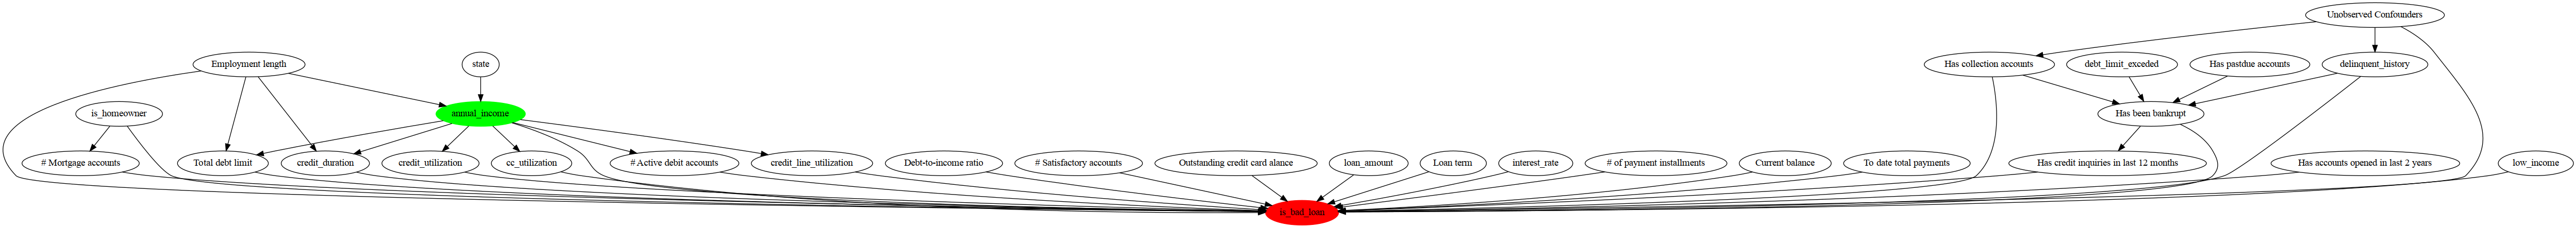

In [227]:
model= dowhy.CausalModel(
        data = df,
        graph='causal_graph_has_deliquent_history.dot',
        treatment=['delinquent_history','has_collection_accounts'],
        outcome='is_bad_loan',
        #treatment_is_binary=False,
        control_value=(1,1),
        treatment_value=(0,0)
)
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png",width = 5000, height = 100))

In [228]:
model.interpret()

Model to find the causal effect of treatment ['delinquent_history', 'has_collection_accounts'] on outcome ['is_bad_loan']


### Step-2. Identify the Causal Effect

In [229]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
#print(identified_estimand)

### Step-3. Estimate the identified estimand

In [230]:
#'backdoor.propensity_score_stratification','propensity_score_matching','iv.instrumental_variable'
estimates_list = []
methods_list = ['backdoor.linear_regression','backdoor.propensity_score_stratification']
method_param_list = [None, None] 
for i in range(len(methods_list)):
    print('Estimating--------------->', methods_list[i])
    estimate = model.estimate_effect(identified_estimand,
                                     method_name=methods_list[i],
                                     method_params=method_param_list[i],
                                     target_units="ate",test_significance=True)
    estimates_list.append(estimate)
    print(estimate)

Estimating---------------> backdoor.linear_regression
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                      d                                                       
──────────────────────────────────────────────(Expectation(is_bad_loan|has_pas
d[delinquent_history  has_collection_accounts]                                

                                                                              
t_due_accounts,installment,emp_length,term,num_active_debit_accounts,balance,n
                                                                              

                                                                              
um_satisfactory_accounts,debt_to_income,paid_total,has_accounts_opened_24m,cre
                                                                              

                                                                              
dit_utili

In [231]:
#estimate = model.estimate_effect(identified_estimand, 
#                                 method_name="backdoor.propensity_score_matching", test_significance=True)
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
#print(estimate)

### Step-4. Refute results

##### Radom Common Cause:
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

#### Placebo Treatment Refuter:
Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

#### Data Subset Refuter:
Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [232]:
refuter_list = ["placebo_treatment_refuter","data_subset_refuter", "random_common_cause"]
refutation_list = []
inspect_refutations=True
refuter_count = 1

for estimate in estimates_list:
    for refuter in refuter_list:
        refute_estimate = model.refute_estimate(identified_estimand, estimate, method_name=refuter)
        refutation_list.append(refute_estimate)

if inspect_refutations is True:
    for refutation in refutation_list:
        print("####### Refutation {}######################################################".format(refuter_count))
        print("*** Class Name ***")
        print()
        print(refutation.refutation_type)
        print()
        print(refutation)
        print("############################################################################")
        print()
        refuter_count += 1

IndentationError: expected an indented block (<ipython-input-232-3484eedede87>, line 10)